## Automatic prompt optimization

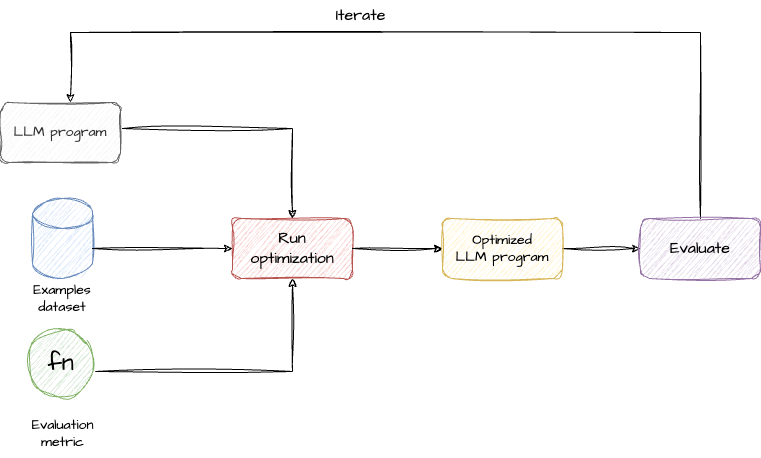

In [ ]:
%env DSP_CACHEBOOL=false

## Prepare train/test datasets

In [ ]:
%run ./module-00-data-prep.ipynb
train = train
val = val
test = test
len(train), len(val), len(test)

## Connections

In [ ]:
import dspy

MODEL = "qwen2.5:1.5b"


lm = dspy.OllamaLocal(
    model=MODEL,
)
dspy.configure(lm=lm)

dspy.settings.configure(lm=lm)

## Program definition

In [ ]:
from sms_classifier import SMSClassifier

sms_classifier = SMSClassifier(lm)

## Setup prompt BootstrapFewShotWithRandomSearch optimizer 



In [ ]:
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
from evaluation_helpers import validate_answer

config = dict(
    max_bootstrapped_demos=4,
    max_labeled_demos=8,
    num_candidate_programs=16,
    num_threads=1,
    max_errors=10,
)

teleprompter = BootstrapFewShotWithRandomSearch(metric=validate_answer, **config)
optimized_program = teleprompter.compile(sms_classifier, trainset=train[:100])

... this process can take some time - mostly depending on the train dataset size and number of candidate programs. Beware of the costs if using a commercial model!

Once the process is done and you're satisfied with the results you can save a model for later use.
```python
optimized_program.save(f"programs/sms_classifier-{MODEL}.json")
```
Take a sneak peek into its internals...

### Evaluation

Let's start with loading the model.

In [ ]:
from sms_classifier import SMSClassifier

optimized_classifier = SMSClassifier(lm)
optimized_classifier.load(f"programs/sms_classifier-{MODEL}.json")

In [ ]:
from datetime import datetime

from evaluation_helpers import validate_answer

from notebooks.cybersecurity.langfuse_extensions import EvaluateWithLangfuse

session = f"Run-{MODEL}-optim-{int(datetime.now().timestamp())}"
print(session)
evaluator = EvaluateWithLangfuse(
    devset=test, num_threads=1, display_progress=True, run_id=session
)
evaluator(optimized_classifier, metric=validate_answer)

### Load previous saved program


In [ ]:
## After running the optimization

In [ ]:
from evaluation_helpers import calculate_metrics, fetch_traces
from sms_classifier import Label

classes = [l.value for l in Label]

In [ ]:
# Run-qwen2.5:7b-optim-1729433657
traces_qwen25_7_optim = fetch_traces(run_id="Run-qwen2.5:7b-optim-1729433657")
metrics_qwen25_7_optim = calculate_metrics(traces_qwen25_7_optim, classes)
metrics_qwen25_7_optim["macro"]

In [ ]:
# Run-gemma2:9b-optim-1729434900
traces_gemma2_9_optim = fetch_traces(run_id="Run-gemma2:9b-optim-1729434900")
metrics_gemma2_9_optim = calculate_metrics(traces_gemma2_9_optim, classes)
metrics_gemma2_9_optim["macro"]

In [ ]:
# Run-llama3.1:8b-optim-1729436001
traces_llama31_8_optim = fetch_traces(run_id="Run-llama3.1:8b-optim-1729436001")
metrics_llama31_8_optim = calculate_metrics(traces_llama31_8_optim, classes)
metrics_llama31_8_optim["macro"]

In [ ]:
# Run-qwen2.5:1.5b-optim-1729436454
traces_qwen25_1_5_optim = fetch_traces(run_id="Run-qwen2.5:1.5b-optim-1729436454")
metrics_qwen25_1_5_optim = calculate_metrics(traces_qwen25_1_5_optim, classes)
metrics_qwen25_1_5_optim["macro"]

In [ ]:
# Run-qwen2.5:3b-optim-1729437009
traces_qwen25_3_optim = fetch_traces(run_id="Run-qwen2.5:3b-optim-1729437009")
metrics_qwen25_3_optim = calculate_metrics(traces_qwen25_3_optim, classes)
metrics_qwen25_3_optim["macro"]

In [ ]:
# Run-qwen2.5:0.5b-optim-1729437842
traces_qwen25_0_5_optim = fetch_traces(run_id="Run-qwen2.5:0.5b-optim-1729437842")
metrics_qwen25_0_5_optim = calculate_metrics(traces_qwen25_0_5_optim, classes)
metrics_qwen25_0_5_optim["macro"]

In [ ]:
# Run-gpt-4o-ai-factory-1729432239
traces_gpt_4 = fetch_traces(run_id="Run-gpt-4o-ai-factory-1729432239")
metrics_gpt_4 = calculate_metrics(traces_gpt_4, classes)
metrics_gpt_4["macro"]

In [ ]:
# Run-llama3.1:8b-cyber-1-1729567899
traces_llama31_8_cyber = fetch_traces(run_id="Run-llama3.1:8b-cyber-1-1729567899")
metrics_llama31_8_cyber = calculate_metrics(traces_llama31_8_cyber, classes)
metrics_llama31_8_cyber["macro"]

In [ ]:
metrics_optim = dict()
metrics_optim["qwen2.5:0.5b"] = metrics_qwen25_0_5_optim["macro"]
metrics_optim["qwen2.5:1.5b"] = metrics_qwen25_1_5_optim["macro"]
metrics_optim["qwen2.5:3b"] = metrics_qwen25_3_optim["macro"]
metrics_optim["qwen2.5:7b"] = metrics_qwen25_7_optim["macro"]
metrics_optim["gemma2:9b"] = metrics_gemma2_9_optim["macro"]
metrics_optim["llama3.1:8b"] = metrics_llama31_8_optim["macro"]
metrics_optim["llama3.1:8b-cyber"] = metrics_llama31_8_cyber["macro"]
metrics_optim["gpt-4o-ai-factory-baseline"] = metrics_gpt_4["macro"]

In [ ]:
from evaluation_helpers import plot_metrics

plot_metrics(
    metrics_optim, ["Precision", "Recall", "F1"], "Scores by model after optimization"
)